**Esta rotina foi criada para discutir o tema "Valuation"**  
**Prof Antonio Francisco**  
pantoniofran.wixsite.com/sitio  
Empresa analisada: Klabin  
Esses cálculos têm apenas fins didáticos


In [7]:
# @title
# Carrega bibliotecas
#Quando rodar a primeira vez, retirar os comentários abaixo,
#para instalação das bibliotecas de excel

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive/')

import statsmodels.api as sm





Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
# Função para acessar API do BCB

def getBCB(codigo_serieBCB, data_inicioBCB, data_fimBCB):
  # URL da API
  url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serieBCB}/dados?formato=json&dataInicial={data_inicioBCB}&dataFinal={data_fimBCB}'

  # Baixar os dados
  try:
    response = requests.get(url)
    response.raise_for_status()  # Verifica erros na requisição
    dados = response.json()

    # Converter para DataFrame
    dfBCB = pd.DataFrame(dados)
    dfBCB['data'] = pd.to_datetime(dfBCB['data'], dayfirst=True)
    dfBCB['valor'] = dfBCB['valor'].astype(float)

    # Mostrar resultados

  except Exception as e:
    print(f"Erro ao acessar a API: {e}")

  return dfBCB

In [9]:
# Pegando dados de ações no Yahoo Finance

data_inicio = '01/01/2017'
data_fim = '31/03/2025'
# Converte a string para datetime
data_dt1 = datetime.strptime(data_inicio, '%d/%m/%Y')
data_dt2 = datetime.strptime(data_fim, '%d/%m/%Y')
# Formata no novo padrão
data_inicio_formatada = data_dt1.strftime('%Y-%m-%d')
data_fim_formatada = data_dt2.strftime('%Y-%m-%d')

# Ticker da ação no Yahoo Finance
acoes = ['KLBN11.SA', 'KLBN3.SA', 'KLBN4.SA', '^BVSP']

buscaYahoo = True

arquivo = "/content/drive/My Drive/Colab Notebooks/retornosValuationKlabin.xlsx"
if buscaYahoo == True:
  # Coleta os dados históricos
  dadosAcoes = yf.download(acoes, start=data_inicio_formatada, end=data_fim_formatada)

  retornosAcoes = dadosAcoes['Close'].pct_change()
  # Define o caminho onde o arquivo será salvo no Google Drive
  # Salva o DataFrame como um arquivo Excel
  retornosAcoes.to_excel(arquivo, index=True)
else:
  retornosAcoes = pd.read_excel(arquivo, index_col=0)

retornosAcoes.index.name = 'Data'

[*********************100%***********************]  4 of 4 completed
<ipython-input-9-24aada0c3610>:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornosAcoes = dadosAcoes['Close'].pct_change()


In [10]:
# Captura de dados da taxa Selic e da taxa de câmbio

# Configurações
codigo_serie_selic = 11  # Código da SELIC diária no SGS
codigo_serie_BRL = 1  # Código da taxa de câmbio diária no SGS

df_selic = getBCB(codigo_serie_selic, data_inicio, data_fim)
df_selic['valor'] = df_selic['valor'] / 100
df_selic.index.name = 'Data'

df_BRL = getBCB(codigo_serie_BRL, data_inicio, data_fim)


In [11]:
# Captura das Contas do Balanço Patrimonial, DRE e DFC

caminho1 = '/content/drive/My Drive/Colab Notebooks/'
arquivo1 = 'Planilha de Resultados 4T24.xlsx'

df_bp=pd.read_excel(f'{caminho1}{arquivo1}', sheet_name= '3. Balanço Patrimonial', skiprows=1)
df_dre=pd.read_excel(f'{caminho1}{arquivo1}', sheet_name= '4. DRE', skiprows=1)
df_fc = pd.read_excel(f'{caminho1}{arquivo1}', sheet_name= '9. Fluxo de Caixa Livre', skiprows=1)
df_dfc = pd.read_excel(f'{caminho1}{arquivo1}', sheet_name= '5. Fluxo de Caixa (New)', skiprows=1)
df_dfc_Old = pd.read_excel(f'{caminho1}{arquivo1}', sheet_name= '5. Fluxo de Caixa (Old)', skiprows=1)


df_bp.set_index('Balanço Patrimonial (R$ milhões)', inplace=True)
df_dre.set_index('DRE (R$ milhões)', inplace=True)
df_fc.set_index('Fluxo de Caixa Livre (R$ milhões)', inplace=True)
df_dfc.set_index('Demonstração de Fluxo de Caixa (R$ mil)', inplace=True)
df_dfc_Old.set_index('Demonstração de Fluxo de Caixa (R$ mil)', inplace=True)


In [12]:
# Organizando DataFrame com Contas da DRE

x=df_dre.columns
x=x[1:len(x)]
z=(x.str.isnumeric()).isna()
xDatas=x[(x.str.isnumeric()).isna()]

df_rl=pd.DataFrame(df_dre.loc['Receita Líquida'][xDatas])
df_rl.columns = ['Valor']
df_rl.index.name = 'Data'
dt={'Data':df_rl.index}

df_cpv=pd.DataFrame(df_dre.loc['Custo dos Produtos Vendidos'][xDatas]) * (-1)
df_cpv.columns = ['Valor']
df_cpv.index.name = 'Data'

df_ebit=pd.DataFrame(df_dre.loc['Resultado Oper. antes Desp. Fin. (EBIT)'][xDatas])
df_ebit.columns = ['Valor']
df_ebit.index.name = 'Data'

df_ebitda=pd.DataFrame(df_dre.loc['EBITDA'][xDatas])
df_ebitda.columns = ['Valor']
df_ebitda.index.name = 'Data'

df_dfin = pd.DataFrame(df_dre.loc['Despesas Financeiras'][xDatas]) * (-1)
df_dfin.columns = ['Valor']
df_dfin.index.name = 'Data'

df_lbr = pd.DataFrame(df_dre.loc['Lucro Bruto'][xDatas])
df_lbr.columns = ['Valor']
df_lbr.index.name = 'Data'

df_llq = pd.DataFrame(df_dre.loc['Lucro (Prejuizo) Líquido'][xDatas])
df_llq.columns = ['Valor']
df_llq.index.name = 'Data'

In [13]:
#Organizando DataFrame com Contas do balanço
x=df_bp.columns[df_bp.columns.str.contains('4T')]
df_ac=pd.DataFrame(df_bp.loc['Ativo Circulante'][x])
df_cx=pd.DataFrame(df_bp.loc['Caixa e equivalente de caixa'][x])

df_es=pd.DataFrame(df_bp.loc['Estoques'][x])
df_cr=pd.DataFrame(df_bp.loc['Contas a Receber'][x])
df_fr=pd.DataFrame(df_bp.loc['Fornecedores'][x])

df_pc=pd.DataFrame(df_bp.loc['Passivo Circulante'][x])
df_pnc=pd.DataFrame(df_bp.loc['Passivo Não Circulante'][x])
df_efin=pd.DataFrame(df_bp.loc['Empréstimos e financiamentos e debêntures'][x])
#df_deb=pd.DataFrame(df_bp.loc['Debentures'][x])
df_ppl=pd.DataFrame(df_bp.loc['Passivo Total + Patrimônio Líquido'][x])

df_ac.columns = ['Valor']
df_ac['Data'] = dt['Data']
df_ac.set_index('Data', inplace=True )
df_pc.columns = ['Valor']
df_pc['Data'] = dt['Data']
df_pc.set_index('Data', inplace=True )
df_cx.columns = ['Valor']
df_cx['Data'] = dt['Data']
df_cx.set_index('Data', inplace=True )
df_es.columns = ['Valor']
df_es['Data'] = dt['Data']
df_es.set_index('Data', inplace=True )
df_cr.columns = ['Valor']
df_cr['Data'] = dt['Data']
df_cr.set_index('Data', inplace=True )
df_fr = pd.DataFrame(df_fr.sum(axis = 0) )
df_fr.columns = ['Valor']
df_fr['Data'] = dt['Data']
df_fr.set_index('Data', inplace=True )
df_pnc.columns = ['Valor']
df_pnc['Data'] = dt['Data']
df_pnc.set_index('Data', inplace=True )
df_efin = pd.DataFrame(df_efin.sum(axis = 0) )
df_efin.columns = ['Valor']
df_efin['Data'] = dt['Data']
df_efin.set_index('Data', inplace=True )
#df_deb = pd.DataFrame(df_deb.sum(axis = 0) )
#df_deb.columns = ['Valor']
#df_deb['Data'] = dt['Data']
#df_deb.set_index('Data', inplace=True )
df_ppl.columns = ['Valor']
df_ppl['Data'] = dt['Data']
df_ppl.set_index('Data', inplace=True )


In [14]:
# Organizando DataFrame com Contas da Planilha de Fluxo de Caixa Livre

x=df_fc.columns
x=x[1:len(x)]
z=(x.str.isnumeric()).isna()
xDatasFC=x[(x.str.isnumeric()).isna()]

df_dividendos=pd.DataFrame(df_fc.loc['Dividendos & JCP'][xDatasFC])
df_dividendos.columns = ['Valor']
df_dividendos.index.name = 'Data'

df_juros=pd.DataFrame(df_fc.loc['(-) Juros Pagos/Recebidos'][xDatasFC])
df_juros.columns = ['Valor']
df_juros.index.name = 'Data'

df_fcla=pd.DataFrame(df_fc.loc['Fluxo de Caixa Livre ajustado³'][xDatasFC])
df_fcla.columns = ['Valor']
df_fcla.index.name = 'Data'

df_editdaAjustado=pd.DataFrame(df_fc.loc['EBITDA Ajustado¹'][xDatasFC])
df_editdaAjustado.columns = ['Valor']
df_editdaAjustado.index.name = 'Data'



In [15]:
# Organizando o DataFrame das contas da DFC
x=df_dfc.columns
x=x[1:len(x)]
z=(x.str.isnumeric()).isna()
xDatasDFC=x[(x.str.isnumeric()).isna()]

df_emissoes=pd.DataFrame(df_dfc.loc['Captação de empréstimos, financiamentos e debêntures'][xDatasDFC]) / 1000
df_emissoes.columns = ['Valor']
df_emissoes.index.name = 'Data'

df_amortizacoes=pd.DataFrame(df_dfc.loc['Amortização de empréstimos e financiamentos e debêntures'][xDatasDFC]) / 1000
df_amortizacoes.columns = ['Valor']
df_amortizacoes.index.name = 'Data'

x=df_dfc_Old.columns
x=x[1:len(x)]
z=(x.str.isnumeric()).isna()
xDatasDFC_Old=x[(x.str.isnumeric()).isna()]

df_emissoes_Old=pd.DataFrame(df_dfc_Old.loc['Captação de Empréstimos e Financiamentos'][xDatasDFC_Old]) / 1000
df_emissoes_Old.columns = ['Valor']
df_emissoes_Old.index.name = 'Data'

df_amortizacoes_Old=pd.DataFrame(df_dfc_Old.loc['Amortização de Empréstimos, Financiamentos e Debêntures'][xDatasDFC_Old]) / 1000
df_amortizacoes_Old.columns = ['Valor']
df_amortizacoes_Old.index.name = 'Data'

df_amortizacoes = df_amortizacoes_Old.combine_first(df_amortizacoes)
df_emissoes = df_emissoes_Old.combine_first(df_emissoes)


In [16]:
#Cálculo do BETA

# 1. Ajusta o df_selic (se já não tiver feito)
df_selic1 = df_selic.copy()
df_selic1['data'] = pd.to_datetime(df_selic1['data'])
df_selic1.set_index('data', inplace=True)
df_selic1.rename(columns={'valor': 'selic_diaria'}, inplace=True)

# 2. Junta os retornos das ações com a Selic diária
df_merged = retornosAcoes.merge(df_selic1, left_index=True, right_index=True, how='inner')
df_merged['selic_diaria'] = df_merged['selic_diaria'].astype(float)

df_merged['selic_diaria'] = pd.to_numeric(df_merged['selic_diaria'], errors='coerce')
df_merged.dropna(subset=['selic_diaria'], inplace=True)  # Remove valores inválidos


# 3. Calcula os retornos em excesso (ações - selic)
retornos_excesso = df_merged.drop(columns=['^BVSP']).sub(df_merged['selic_diaria'], axis=0)

# 4. Calcula retorno em excesso do mercado (Ibovespa - selic)
retorno_mercado_excesso = df_merged['^BVSP'] - df_merged['selic_diaria']

# 5. Calcula o beta de cada ação
retornos_excesso = retornos_excesso.drop(columns=['selic_diaria'], errors='ignore')

resultados = []

for acao in retornos_excesso.columns:
    y = retornos_excesso[acao]
    X = pd.DataFrame({'mercado': retorno_mercado_excesso})
    X = sm.add_constant(X)

    modelo = sm.OLS(y, X, missing='drop').fit()

    resultados.append({
        'Ação': acao,
        'Beta': modelo.params['mercado'],
        'Alfa': modelo.params['const'],
        'R²': modelo.rsquared
    })

df_resultados = pd.DataFrame(resultados)
#print(df_resultados)

betaCAPM = df_resultados['Beta'].mean()

taxaLivreRisco = (1+df_selic1['selic_diaria'].tail(22).mean()) ** 252 -1
print("Taxa livre de Risco: ", taxaLivreRisco)
print("Beta do CAPM: ", betaCAPM)

Taxa livre de Risco:  0.1351254080882618
Beta do CAPM:  0.43561394544602416


Volatilidade Ibovespa anualizada 0.23522939229898038
Volatilidade Selic anual 0.15476227084575198
Prêmio de mercado Brasil estimado sobre a taxa de juros americana : 0.0754


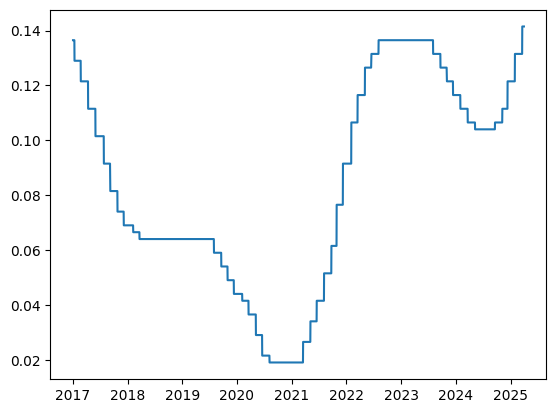

In [17]:
# Calculando o premio esperado para o mercado acionário brasilileiro por um investidor estrangeiro aplicando em Bolsa no Brasil
# Esse prêmio é em USD
# Valores externos (exemplo)
premio_usd = 0.045  # Exemplo de prêmio de risco nos EUA
cds_brasil = 0.02  # Exemplo de CDS do Brasil

durationTitBrasilUSD = 4

vol_ibovespa = retornosAcoes['^BVSP'].std() * np.sqrt(252)  # Ajuste para escala anual

#vol_diaria_Selic = df_selic1['selic_diaria'].std()
df_selic_anual =  (1+df_selic1)**252 - 1
df_selic_anual.columns = ["selic_anual"]
vol_anual_Selic = df_selic_anual["selic_anual"].std()
plt.plot(df_selic_anual.index, df_selic_anual["selic_anual"])
vol_renda_fixa = durationTitBrasilUSD * vol_anual_Selic

print("Volatilidade Ibovespa anualizada", vol_ibovespa)
print("Volatilidade Selic anual", vol_renda_fixa)


# Calculando o prêmio de risco Brasil
premio_brasil_USD = premio_usd + cds_brasil * (vol_ibovespa / vol_renda_fixa)

print(f"Prêmio de mercado Brasil estimado sobre a taxa de juros americana : {premio_brasil_USD:.4f}")


In [18]:
# Premio de um investidor no Brasil (Prêmio em reais)
# Prêmio em R$
# Como a bolsa brasileira em vários períodos paga menos que a Selic, foi considerado um prêmio mínimo
premioMinimo = 0.05


medRetIbov = (1+retornosAcoes['^BVSP'].mean())**252-1
medSelic = (1+df_selic1.mean().values[0])**252-1

premioCalcBRL = medRetIbov-medSelic
premio_brasil_BRL = max(premioMinimo, premioCalcBRL)

print("Retorno médio Ibovespa ", medRetIbov)
print("Retorno médio Selic ", medSelic)
print("Prêmio mínimo ", premioMinimo)
print("Prêmio BRL calculado ", premioCalcBRL)
print("Prêmio de mercado em BRL a ser usado sobre a Selic: ", premio_brasil_BRL)

Retorno médio Ibovespa  0.13380345774114
Retorno médio Selic  0.0834270093760161
Prêmio mínimo  0.05
Prêmio BRL calculado  0.050376448365123894
Prêmio de mercado em BRL a ser usado sobre a Selic:  0.050376448365123894


In [19]:
# Cálculo do custo do capital próprio
# São consideradas quatro abordagens para o custo do capital próprio
# a) Selic + beta * prêmio de mercado brasileiro                          # com valor mínimo
# b) Taxa Juros EUA + beta * premio de mercado brasileiro em USD          # ótica do investidor internacional
# c) Selic + beta * premio de mercado brasileiro em USD                   # tentativa de correção do Ibovespa pagar menos do que a Selic
# d) Uso da ótica do investidor internacional, corrigindo pela inflação   # tentativa de correção do Ibovespa pagar menos do que a Selic

inflacaoBrasil = 0.05
inflacaoEUA = 0.025
premio_brasil_USD_ref = 0.08


k_e = taxaLivreRisco + betaCAPM * premio_brasil_BRL
k_e_USD = 0.05 + betaCAPM * premio_brasil_USD_ref
k_e_mix = taxaLivreRisco + betaCAPM * premio_brasil_USD
k_e_Inflacao = k_e_USD * (1+inflacaoBrasil)/(1+inflacaoEUA)

print("Custo do capital próprio")
print("A- Considerando Ibovespa e Selic:" , k_e)
print("B- Considerando USD: ", k_e_USD)
print("C- Considerando prêmio USD e Selic: ", k_e_mix)
print("D- Considerando prêmio em USD e corrigindo inflação: ", k_e_Inflacao)



Custo do capital próprio
A- Considerando Ibovespa e Selic: 0.15707009151815132
B- Considerando USD:  0.08484911563568193
C- Considerando prêmio USD e Selic:  0.1679701783215024
D- Considerando prêmio em USD e corrigindo inflação:  0.08691860626094247


In [20]:
# Converter a coluna 'data' para datetime
df_BRL_1 = df_BRL.copy()
df_BRL_1['data'] = pd.to_datetime(df_BRL_1['data'])

# Criar uma nova coluna com apenas o ano
df_BRL_1['Data'] = df_BRL_1['data'].dt.year

# Calcular a média dos valores por ano
df_BRL_ano = df_BRL_1.groupby('Data')['valor'].mean().rename('valor').to_frame()
# Exibir o resultado
print(df_BRL_ano)


         valor
Data          
2017  3.192545
2018  3.655784
2019  3.946119
2020  5.157773
2021  5.395561
2022  5.165482
2023  4.995348
2024  5.392016
2025  5.852152


A taxa de crescimento de dividendos em reais após remoção de outliers é:  0.13647823545102758


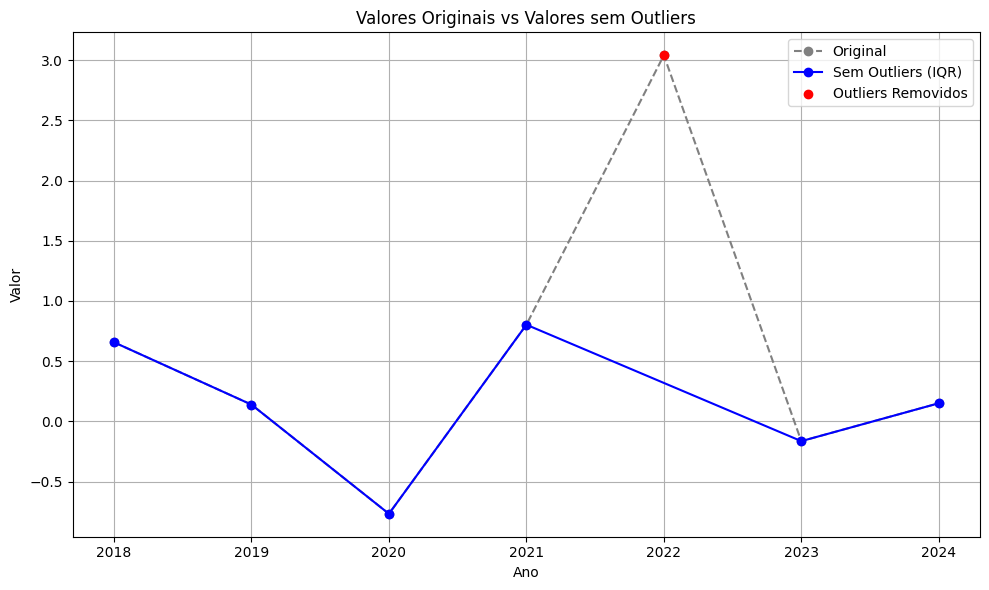

In [21]:
#Taxa de crescimento dos dividendos em reais

df_varDividendos = df_dividendos.pct_change()
#df_varDividendos = df_varDividendos[df_varDividendos.index > 2020]

Q1 = df_varDividendos['Valor'].quantile(0.25)
Q3 = df_varDividendos['Valor'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Remover os outliers
df_varDividendos_sem_outliers = df_varDividendos[(df_varDividendos['Valor'] >= limite_inferior) & (df_varDividendos['Valor'] <= limite_superior)]

#Estimativa da taxa de crescimento de dividendos após remoção de outliers
g_taxaCrescDiv = df_varDividendos_sem_outliers.mean().values[0]
print("A taxa de crescimento de dividendos em reais após remoção de outliers é: ", g_taxaCrescDiv)

df_varDividendos_outliers = df_varDividendos[(df_varDividendos['Valor'] < limite_inferior) | (df_varDividendos['Valor'] > limite_superior)]

# Plotando
# Separando os dados com e sem outliers

# --- Plotagem ---
plt.figure(figsize=(10, 6))

# Dados originais
plt.plot(df_varDividendos.index, df_varDividendos['Valor'], label='Original', marker='o', linestyle='--', color='gray')

# Dados sem outliers
plt.plot(df_varDividendos_sem_outliers.index, df_varDividendos_sem_outliers['Valor'], label='Sem Outliers (IQR)', marker='o', color='blue')

# Outliers destacados
plt.scatter(df_varDividendos_outliers.index, df_varDividendos_outliers['Valor'], label='Outliers Removidos', color='red', zorder=5)

plt.title('Valores Originais vs Valores sem Outliers')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




          valBRL  CotacaoBRL     val_USD
Data                                    
2017  506.910000    3.192545  158.779262
2018  839.914996    3.655784  229.749598
2019  956.940028    3.946119  242.501590
2020  223.000000    5.157773   43.235715
2021  402.000000    5.395561   74.505697
A taxa de crescimento de dividendos em dolar após remoção de outliers é:  0.05578774692992141


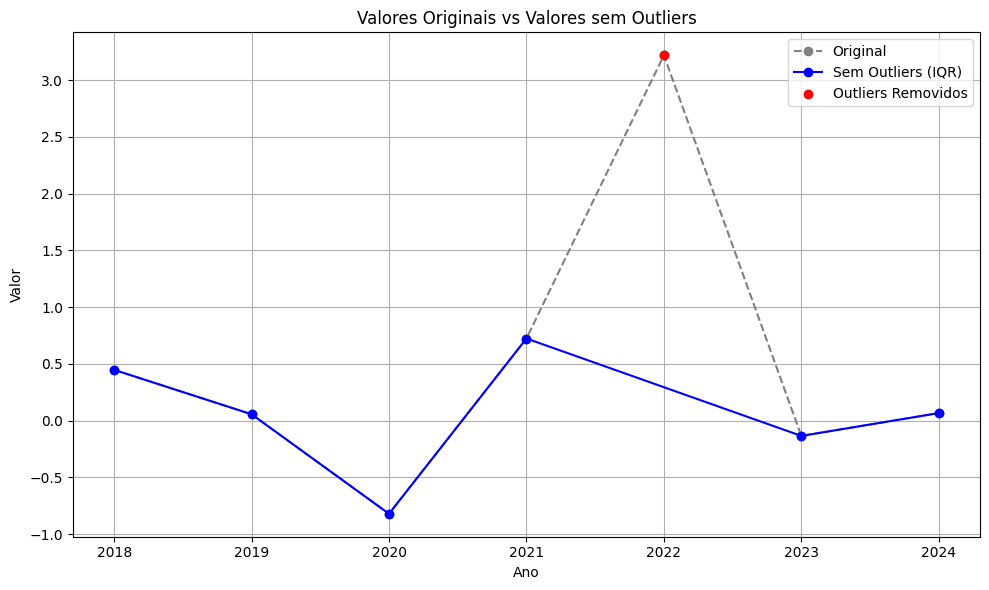

In [22]:
# Taxa de crescimento dos Dividendos em dolar

df_dividendos_USD = df_dividendos.merge(df_BRL_ano, on='Data', how='outer')
df_dividendos_USD.columns = ["valBRL", "CotacaoBRL"]
df_dividendos_USD["val_USD"] = df_dividendos_USD['valBRL'] / df_dividendos_USD['CotacaoBRL']
print(df_dividendos_USD.head())

#Taxa de crescimento dos dividendos em reais

df_varDividendos_USD = df_dividendos_USD.pct_change(fill_method=None)

Q1 = df_varDividendos_USD['val_USD'].quantile(0.25)
Q3 = df_varDividendos_USD['val_USD'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Remover os outliers
df_varDividendos_sem_outliers_USD = df_varDividendos_USD[(df_varDividendos_USD['val_USD'] >= limite_inferior) & (df_varDividendos_USD['val_USD'] <= limite_superior)]

#Estimativa da taxa de crescimento de dividendos após remoção de outliers
g_taxaCrescDiv_USD = df_varDividendos_sem_outliers_USD.mean().values[2]
print("A taxa de crescimento de dividendos em dolar após remoção de outliers é: ", g_taxaCrescDiv_USD)

df_varDividendos_outliers_USD = df_varDividendos_USD[(df_varDividendos_USD['val_USD'] < limite_inferior) | (df_varDividendos_USD['val_USD'] > limite_superior)]

# Plotando
# Separando os dados com e sem outliers

# --- Plotagem ---
plt.figure(figsize=(10, 6))

# Dados originais
plt.plot(df_varDividendos_USD.index, df_varDividendos_USD['val_USD'], label='Original', marker='o', linestyle='--', color='gray')

# Dados sem outliers
plt.plot(df_varDividendos_sem_outliers_USD.index, df_varDividendos_sem_outliers_USD['val_USD'], label='Sem Outliers (IQR)', marker='o', color='blue')

# Outliers destacados
plt.scatter(df_varDividendos_outliers_USD.index, df_varDividendos_outliers_USD['val_USD'], label='Outliers Removidos', color='red', zorder=5)

plt.title('Valores Originais vs Valores sem Outliers')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





In [23]:
# Valor de mercado da empresa pelo modelo de Gordon

print("Valoração a partir dos dividendos")

if k_e > g_taxaCrescDiv:
  valMercadoA = df_dividendos.iloc[-1].values[0] * (1+g_taxaCrescDiv) / (k_e - g_taxaCrescDiv)
  print("Valor a partir de Selic + beta * prêmio de mercado brasileiro: ", valMercadoA)
else:
  print("Não é possível calcular a partir de Selic + beta * prêmio de mercado brasileiro")

if k_e_USD > g_taxaCrescDiv_USD:
  valMercadoB = df_dividendos.iloc[-1].values[0] * (1+g_taxaCrescDiv) / (k_e_USD - g_taxaCrescDiv_USD)
  print("Valor a partir de Taxa Juros EUA + beta * premio de mercado brasileiro em USD: ", valMercadoB)
else:
  print("Não é possível calcular a partir de Taxa Juros EUA + beta * premio de mercado brasileiro em USD")

if k_e_mix > g_taxaCrescDiv:
  valMercadoC = df_dividendos.iloc[-1].values[0] * (1+g_taxaCrescDiv) / (k_e_mix - g_taxaCrescDiv)
  print("Valor a partir de Selic + beta * premio de mercado brasileiro em USD: ", valMercadoC)
else:
  print("Não é possível calcular a partir de Selic + beta * premio de mercado brasileiro em USD")

if k_e_Inflacao > g_taxaCrescDiv:
  valMercadoD = df_dividendos.iloc[-1].values[0] * (1+g_taxaCrescDiv) / (k_e_Inflacao - g_taxaCrescDiv)
  print("Valor a partir do uso da ótica do investidor internacional, corrigindo pela inflação: ", valMercadoD)
else:
  print("Não é possível calcular a partir do uso da ótica do investidor internacional, corrigindo pela inflação")



print("Tomar muito cuidado com as premissas da valoração, pois elas podem chegar a resultados ruins")




Valoração a partir dos dividendos
Valor a partir de Selic + beta * prêmio de mercado brasileiro:  86241.97687238365
Valor a partir de Taxa Juros EUA + beta * premio de mercado brasileiro em USD:  61108.00880305149
Valor a partir de Selic + beta * premio de mercado brasileiro em USD:  56391.64220526107
Não é possível calcular a partir do uso da ótica do investidor internacional, corrigindo pela inflação
Tomar muito cuidado com as premissas da valoração, pois elas podem chegar a resultados ruins


In [24]:
#Dados das ações emitidas pela Klabin (emissões menos em tesouraria)
#Estrutura acionáia consultada em 02/05/2025:https://ri.klabin.com.br/governanca-corporativa/estrutura-acionaria/

num_KLBN11 = 869127558 - 22773184
num_KLBN4 = 3889780576 - 91102399
num_KLBN3 = 2289901455 - 22773184

dadosAcoes1 = dadosAcoes['Close']

valKLBN11 = dadosAcoes1['KLBN11.SA'].iloc[-1]*num_KLBN11 / 1000000
valKLBN4 = dadosAcoes1['KLBN4.SA'].iloc[-1]*num_KLBN4 / 1000000
valKLBN3 = dadosAcoes1['KLBN3.SA'].iloc[-1]*num_KLBN3 / 1000000
valtTotKLBN = valKLBN11 + valKLBN4 + valKLBN3

print("Último Preço KLBN11: ", dadosAcoes1['KLBN11.SA'].iloc[-1])
print("Valor KLBN11: ", num_KLBN11*dadosAcoes1['KLBN11.SA'].iloc[-1]/ 1000000)
print("Último Preço KLBN4: ", dadosAcoes1['KLBN4.SA'].iloc[-1])
print("Valor KLBN11: ", num_KLBN4*dadosAcoes1['KLBN4.SA'].iloc[-1]/ 1000000)
print("Último Preço KLBN3: ", dadosAcoes1['KLBN3.SA'].iloc[-1])
print("Valor KLBN11: ", num_KLBN3*dadosAcoes1['KLBN3.SA'].iloc[-1]/ 1000000)



print("Valor total de mercado: ", valtTotKLBN)



Último Preço KLBN11:  18.78898811340332
Valor KLBN11:  15902.142272812907
Último Preço KLBN4:  3.7555272579193115
Valor KLBN11:  14266.03943778674
Último Preço KLBN3:  3.865269660949707
Valor KLBN11:  8763.062123377667
Valor total de mercado:  38931.243833977314


In [25]:
# Fluxo de caixa livre ao acionista (df_fcfe) e fluxo de caixa livre da firma

g_fcff = 0.075
g_fcfe = 0.075
cargaTrib = 0.25
custoCapTer = 0.15

df_fcfe = df_fcla + df_emissoes + df_amortizacoes
df_fcfe_filtrado = df_fcfe[df_fcfe.index > 2020]
g_taxaCrescFCFE = df_fcfe_filtrado.pct_change(fill_method=None).mean().values[0]

df_fcff = df_fcfe - (df_emissoes + df_amortizacoes) - df_juros * (1-0.30)   #Juros são negativos, logo estamos adicionando
df_fcff_filtrado = df_fcff[df_fcff.index > 2020]
g_taxaCrescFCFF = df_fcff_filtrado.pct_change(fill_method=None).mean().values[0]

print("Taxa de crescimento do fluxo de caixa do acionista é ", g_taxaCrescFCFE)
print("Taxa de crescimento do fluxo de caixa da firma é ", g_taxaCrescFCFF)
print("A taxa de crescimento dos dividendos é: ",g_taxaCrescDiv)
print("O custo do capital próprio é: ", k_e)
fcfe = df_fcfe.tail(4).mean().values[0]
fcff = df_fcff.tail(4).mean().values[0]

razao_passivos = ((df_pc + df_pnc)/df_ppl).iloc[-1].values[0]
razao_pl = 1 - razao_passivos
totpassivos = (df_pc + df_pnc).iloc[-1].values[0]

wacc = k_e *(1-razao_passivos) + razao_passivos * custoCapTer * (1-cargaTrib)
print("O WACC é: ", wacc)

v_fcfe = fcfe *(1+g_fcfe) /(k_e-g_fcfe)
v_fcff = fcff * (1+g_fcff)/(wacc-g_fcff)

print("fcfe é: ", fcfe)
print("fcff é: ", fcff)
print("Valor a partir do fcfe: ", v_fcfe)
print("Valor a partir do fcff menos o total dos passivos: ", v_fcff-totpassivos)

v_dividendos = df_dividendos.iloc[-1].values[0] * (1+g_taxaCrescDiv) / (k_e - g_taxaCrescDiv)
print("Valor de mercado a partir dos dividendos: ", v_dividendos)

Taxa de crescimento do fluxo de caixa do acionista é  0.06891129632076458
Taxa de crescimento do fluxo de caixa da firma é  -0.008342507603816348
A taxa de crescimento dos dividendos é:  0.13647823545102758
O custo do capital próprio é:  0.15707009151815132
O WACC é:  0.11898182188221536
fcfe é:  5970.411409323284
fcff é:  4385.842998369812
Valor a partir do fcfe:  78203.79076344793
Valor a partir do fcff menos o total dos passivos:  56444.774557006065
Valor de mercado a partir dos dividendos:  86241.97687238365
